#### Model Building & Evaluation

This is where we build the actual model to use in Production

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import time

def find_project_root():
    """Find the housing_price_project directory."""
    current = Path.cwd().resolve()
    
    # Check if we're in notebooks/ - go up one level
    if current.name == 'notebooks':
        parent = current.parent
        if (parent / 'src').exists() and (parent / 'notebooks').exists():
            return parent
    
    # Search up the directory tree for housing_price_project
    path = current
    while path != path.parent:
        if path.name == 'housing_price_project' and (path / 'src').exists():
            return path
        path = path.parent
    
    # If not found, assume current directory is project root
    return current

def find_main_project_root():
    """Find the main project root directory."""
    current = Path.cwd().resolve()

    if current.name == "notebooks":
        parent = current.parent.parent

        if (parent / "housing_price_project").exists() and (parent / "linear_regression").exists():
            return parent
        
    path = current
    while path != path.parent:
        if path.name == "hands-on-ml" and (path / "housing_price_project").exists():
            return path
        path = path.parent

    return current


project_root = find_project_root()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

main_project_root = find_main_project_root()
if str(main_project_root) not in sys.path:
    sys.path.insert(0, str(main_project_root))


In [2]:
from linear_regression.core.linear_regression import LinearRegressionGD
from linear_regression.core.regularized import RidgeRegression, LassoRegression, ElasticNetRegression
from linear_regression.preprocessing.scalers import StandardScaler, MinMaxScaler
from linear_regression.preprocessing.pipeline import Pipeline
from linear_regression.model_selection.cross_validation import KFold, cross_val_score, cross_val_predict
from housing_price_project.models.tuning import GridSearchCV, RandomizedSearchCV
from housing_price_project.models.evaluation import train_test_split, r2_score, rmse, mae, mape, rmsle, evaluate_model

In [3]:
DATA_PATH = Path(project_root / "data" / "features" / "ames_featured.csv")
df = pd.read_csv(DATA_PATH)
print(f"Loaded data: {df.shape}")

Loaded data: (2685, 206)


In [4]:
df.head()

,area,MS.SubClass,Lot.Frontage,Lot.Area,Lot.Shape,Land.Slope,Neighborhood,Overall.Qual,Overall.Cond,Year.Built,...,Has_Pool,Has_Fireplace,Has_2nd_Floor,Has_Basement,Sold_Spring,Sold_Summer,Sold_Fall,Sold_Winter,price,log_price
0,7.412764,20,141.0,10.366309,2,2,145697.148333,6,5,1960,...,0,1,0,1,1,0,0,0,215000,12.278398
1,6.799056,20,80.0,9.360741,3,2,145697.148333,5,6,1961,...,0,0,0,1,0,1,0,0,105000,11.561725
2,7.192934,20,81.0,9.565775,2,2,145697.148333,6,6,1958,...,0,0,0,1,0,1,0,0,172000,12.055256
3,7.654917,20,93.0,9.320181,3,2,145697.148333,7,5,1968,...,0,1,0,1,1,0,0,0,244000,12.404928
4,7.396335,60,74.0,9.534668,2,2,187381.912477,5,5,1997,...,0,1,1,1,1,0,0,0,189900,12.154258


In [5]:
target_cols = ["price", "log_price"]
feature_cols = [col for col in df.columns if col not in target_cols]

X = df[feature_cols].values
y = df[target_cols[0]].values
y_log = df[target_cols[1]].values

print(f"Features: {X.shape}")
print(f"Target range: ${y.min():,.0f} - ${y.max():,.0f}")

Features: (2685, 204)
Target range: $12,789 - $755,000


In [6]:
# Use 80/20 split with shuffle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Also split log-transformed target
_, _, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 2148 samples
Test set: 537 samples


In [7]:
# Baseline 1: Predict mean
y_pred_mean = np.full_like(y_test, y_train.mean())
baseline_mean_rmse = rmse(y_test, y_pred_mean)

# Baseline 2: Predict median
y_pred_median = np.full_like(y_test, np.median(y_train))
baseline_median_rmse = rmse(y_test, y_pred_median)

print(f"\nBaseline (predict mean):   RMSE = ${baseline_mean_rmse:,.0f}")
print(f"Baseline (predict median): RMSE = ${baseline_median_rmse:,.0f}")
print(f"\n→ Our models must beat RMSE < ${baseline_mean_rmse:,.0f} to be useful!")


Baseline (predict mean):   RMSE = $70,880
Baseline (predict median): RMSE = $72,825

→ Our models must beat RMSE < $70,880 to be useful!


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaling fitted on training data")
print(f"Train mean after scaling: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"Train std after scaling: {X_train_scaled.std():.6f} (should be ~1)")

Scaling fitted on training data
Train mean after scaling: 0.000000 (should be ~0)
Train std after scaling: 0.987669 (should be ~1)


In [9]:
print("\n" + "="*60)
print("STEP 4: MODEL COMPARISON (Cross-Validation)")
print("="*60)

# We'll compare models using CV on training data
# Using log-transformed target for better performance

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Linear Regression': LinearRegressionGD(),
    'Ridge (α=0.01)': RidgeRegression(alpha=0.01),
    'Ridge (α=0.1)': RidgeRegression(alpha=0.1),
    'Ridge (α=1)': RidgeRegression(alpha=1.0),
    'Ridge (α=10)': RidgeRegression(alpha=10.0),
    'Ridge (α=100)': RidgeRegression(alpha=100.0),
    'Lasso (α=0.001)': LassoRegression(alpha=0.001, max_iter=1000),
    'Lasso (α=0.01)': LassoRegression(alpha=0.01, max_iter=1000),
    'Lasso (α=0.1)': LassoRegression(alpha=0.1, max_iter=1000),
    'ElasticNet (α=0.01, r=0.5)': ElasticNetRegression(alpha=0.01, l1_ratio=0.5, max_iter=1000),
}

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    start_time = time.time()
    scores = cross_val_score(pipeline, X_train, y_train_log, cv=cv, scoring='r2')
    cv_time = time.time() - start_time

    results.append({
        'Model': name,
        'CV R² Mean': scores.mean(),
        'CV R² Std': scores.std(),
        'Time (s)': cv_time
    })
    
    print(f"{name:30s} R² = {scores.mean():.4f} (±{scores.std():.4f})")

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results).sort_values('CV R² Mean', ascending=False)
print("\n" + "-"*60)
print("\nRanked by CV R²:")
print(results_df.to_string(index=False))


STEP 4: MODEL COMPARISON (Cross-Validation)
Converged after 729 iterations
Converged after 726 iterations
Converged after 723 iterations
Converged after 726 iterations
Converged after 728 iterations
Linear Regression              R² = 0.9013 (±0.0174)
Ridge (α=0.01)                 R² = 0.8865 (±0.0140)
Ridge (α=0.1)                  R² = 0.8886 (±0.0138)
Ridge (α=1)                    R² = 0.8955 (±0.0157)
Ridge (α=10)                   R² = 0.9008 (±0.0177)
Ridge (α=100)                  R² = 0.9044 (±0.0176)
Lasso (α=0.001)                R² = 0.9060 (±0.0178)
Lasso (α=0.01)                 R² = 0.9033 (±0.0201)
Lasso (α=0.1)                  R² = 0.7360 (±0.0340)
ElasticNet (α=0.01, r=0.5)     R² = 0.9039 (±0.0194)

------------------------------------------------------------

Ranked by CV R²:
                     Model  CV R² Mean  CV R² Std  Time (s)
           Lasso (α=0.001)    0.906041   0.017772 12.644139
             Ridge (α=100)    0.904403   0.017627  0.023252
ElasticNet

In [10]:
print("\n" + "="*60)
print("STEP 5: HYPERPARAMETER TUNING (Grid Search)")
print("="*60)

print("\n --- Tuning Ridge ---")

ridge_params = {'alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000]}

ridge_grid = GridSearchCV(
    RidgeRegression,
    ridge_params,
    cv=5,
    scoring='r2',
    verbose=1
)
ridge_grid.fit(X_train_scaled, y_train_log)

print(f"\nBest Ridge params: {ridge_grid.best_params_}")
print(f"Best Ridge CV R²: {ridge_grid.best_score_:.4f}")

print("\n --- Tuning Lasso ---")

lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5]}

lasso_grid = GridSearchCV(
    LassoRegression,
    lasso_params,
    cv=5,
    scoring='r2',
    verbose=1
)
lasso_grid.fit(X_train_scaled, y_train_log)

print(f"\nBest Lasso params: {lasso_grid.best_params_}")
print(f"Best Lasso CV R²: {lasso_grid.best_score_:.4f}")

# Tune Elastic Net
print("\n--- Tuning Elastic Net ---")
enet_params = {
    'alpha': [0.001, 0.01, 0.1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

enet_grid = GridSearchCV(
    ElasticNetRegression,
    enet_params,
    cv=5,
    scoring='r2',
    verbose=1
)
enet_grid.fit(X_train_scaled, y_train_log)

print(f"\nBest ElasticNet params: {enet_grid.best_params_}")
print(f"Best ElasticNet CV R²: {enet_grid.best_score_:.4f}")


STEP 5: HYPERPARAMETER TUNING (Grid Search)

 --- Tuning Ridge ---
Grid Search: 8 parameter combinations
Parameters: ['alpha']
CV folds: 5
--------------------------------------------------
  [1/8] {'alpha': 0.01} → r2=0.8865 (±0.0140)
  [2/8] {'alpha': 0.1} → r2=0.8886 (±0.0138)
  [3/8] {'alpha': 1} → r2=0.8955 (±0.0158)
  [4/8] {'alpha': 10} → r2=0.9009 (±0.0176)
  [5/8] {'alpha': 50} → r2=0.9038 (±0.0174)
  [6/8] {'alpha': 100} → r2=0.9049 (±0.0176)
  [7/8] {'alpha': 500} → r2=0.9043 (±0.0200)
  [8/8] {'alpha': 1000} → r2=0.8997 (±0.0221)

Best params: {'alpha': 100}
Best CV score: 0.9049
Refitting on full training data...

Best Ridge params: {'alpha': 100}
Best Ridge CV R²: 0.9049

 --- Tuning Lasso ---
Grid Search: 6 parameter combinations
Parameters: ['alpha']
CV folds: 5
--------------------------------------------------
  [1/6] {'alpha': 0.0001} → r2=0.8987 (±0.0161)
  [2/6] {'alpha': 0.001} → r2=0.9065 (±0.0178)
  [3/6] {'alpha': 0.01} → r2=0.9035 (±0.0200)
  [4/6] {'alpha': 

In [11]:
print("\n" + "="*60)
print("STEP 6: TUNED MODEL COMPARISON")
print("="*60)

tuned_models = {
    'Ridge (tuned)': ridge_grid.best_estimator_,
    'Lasso (tuned)': lasso_grid.best_estimator_,
    'ElasticNet (tuned)': enet_grid.best_estimator_,
}

print("\nTuned model CV scores:")
for name, model in tuned_models.items():
    # Re-run CV to confirm
    scores = []
    for train_idx, val_idx in cv.split(X_train_scaled):
        model_copy = model.__class__(**model.get_params())
        model_copy.fit(X_train_scaled[train_idx], y_train_log[train_idx])
        y_pred = model_copy.predict(X_train_scaled[val_idx])
        scores.append(r2_score(y_train_log[val_idx], y_pred))
    
    print(f"  {name}: R² = {np.mean(scores):.4f} (±{np.std(scores):.4f})")




STEP 6: TUNED MODEL COMPARISON

Tuned model CV scores:
  Ridge (tuned): R² = 0.9049 (±0.0176)
  Lasso (tuned): R² = 0.9065 (±0.0178)
  ElasticNet (tuned): R² = 0.9040 (±0.0190)



STEP 7: FEATURE IMPORTANCE

Lasso selected 133/204 features
Eliminated 71 features (coefficients = 0)

Top 20 most important features (by |coefficient|):
   1. area                           + 0.0866
   2. Qual_Cond_Sum                  + 0.0756
   3. Total_SF                       + 0.0662
   4. Lot.Area                       + 0.0415
   5. Neighborhood                   + 0.0351
   6. House_Age                      - 0.0332
   7. Sale.Condition_Normal          + 0.0267
   8. Bsmt_Finished_Ratio            + 0.0254
   9. Functional                     + 0.0233
  10. Has_Basement                   - 0.0200
  11. Garage.Cond                    + 0.0192
  12. Exterior.1st_BrkFace           + 0.0191
  13. Bsmt.Qual                      + 0.0181
  14. Garage.Cars                    + 0.0178
  15. Kitchen.Qual                   + 0.0177
  16. Bsmt.Exposure                  + 0.0169
  17. X1st.Flr.SF                    + 0.0165
  18. Condition.1_Norm               + 0.0154
  19. Total_Bathr

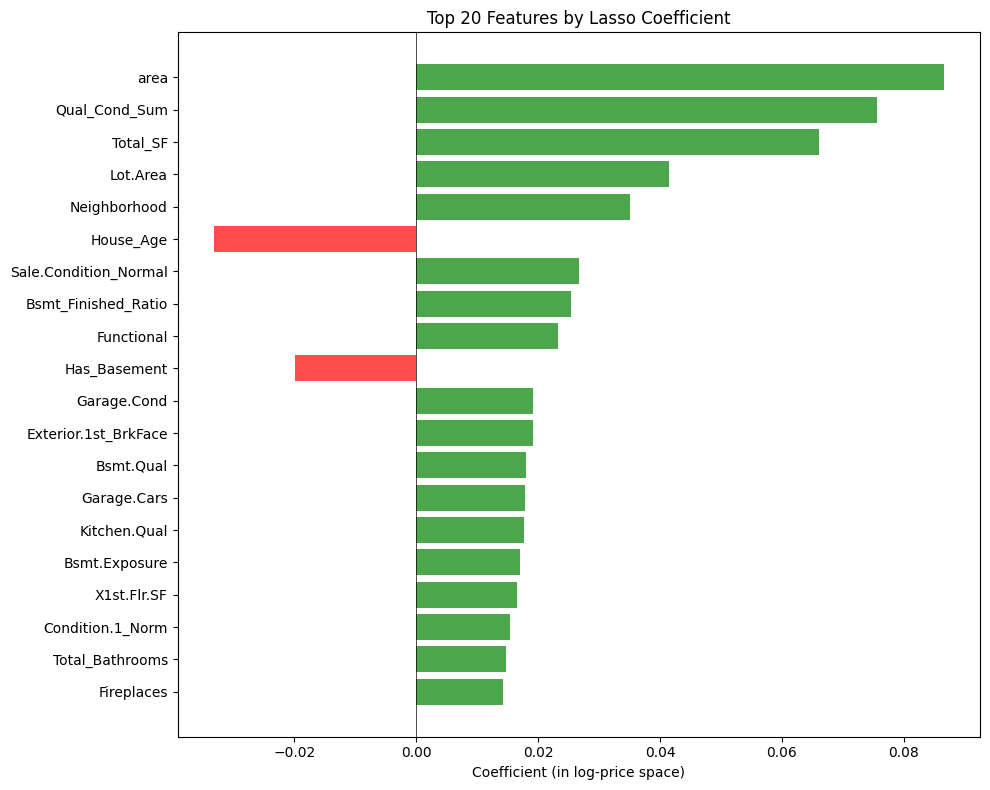

In [14]:
print("\n" + "="*60)
print("STEP 7: FEATURE IMPORTANCE")
print("="*60)

# Lasso provides automatic feature selection!
lasso_best = lasso_grid.best_estimator_
lasso_weights = lasso_best.coef_  # Exclude bias

# Get feature names
feature_names = feature_cols

# Non-zero coefficients
nonzero_mask = np.abs(lasso_weights) > 1e-10
n_selected = np.sum(nonzero_mask)

print(f"\nLasso selected {n_selected}/{len(feature_names)} features")
print(f"Eliminated {len(feature_names) - n_selected} features (coefficients = 0)")

# Top features by absolute weight
weight_importance = list(zip(feature_names, lasso_weights))
weight_importance.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nTop 20 most important features (by |coefficient|):")
for i, (feat, weight) in enumerate(weight_importance[:20]):
    direction = "+" if weight > 0 else "-"
    print(f"  {i+1:2d}. {feat:30s} {direction} {abs(weight):.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
top_features = weight_importance[:top_n]
names = [f[0] for f in top_features]
weights = [f[1] for f in top_features]
colors = ['green' if w > 0 else 'red' for w in weights]

y_pos = np.arange(len(names))
ax.barh(y_pos, weights, color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel('Coefficient (in log-price space)')
ax.set_title(f'Top {top_n} Features by Lasso Coefficient')
ax.axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig(project_root / 'notebooks' / 'feature_importance.png', dpi=150)
plt.show()



STEP 8: LEARNING CURVES


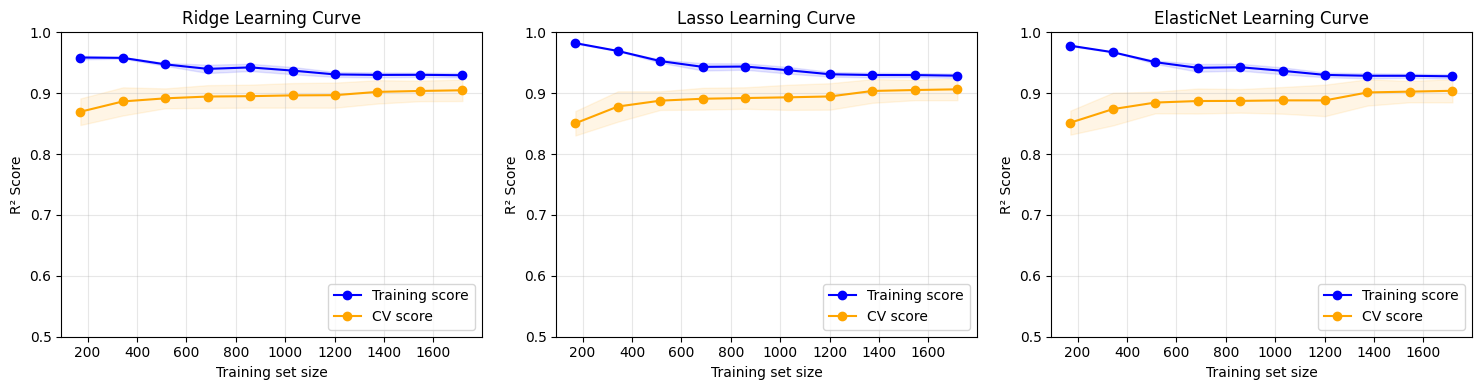


Learning curve interpretation:
  • Gap between train and CV → variance (overfitting)
  • Both scores low → bias (underfitting)
  • Scores converging as size ↑ → more data helps


In [16]:
print("\n" + "="*60)
print("STEP 8: LEARNING CURVES")
print("="*60)

def plot_learning_curves(model, X, y, cv=5, train_sizes=None):
    """
    Plot learning curves to diagnose bias/variance.
    
    High training score, low CV score → Overfitting (high variance)
    Both scores low → Underfitting (high bias)
    Both scores high and close → Good fit!
    """
    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_scores_mean = []
    train_scores_std = []
    cv_scores_mean = []
    cv_scores_std = []
    sizes = []
    
    n_samples = len(X)
    
    for size_frac in train_sizes:
        n_train_max = int(n_samples * size_frac * 0.8)  # Account for CV fold
        
        if n_train_max < 10:
            continue
        
        sizes.append(n_train_max)
        
        # Run CV with limited training size
        train_scores = []
        val_scores = []
        
        cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=42)
        
        for train_idx, val_idx in cv_splitter.split(X):
            # Limit training size
            train_idx = train_idx[:n_train_max]
            
            X_t, X_v = X[train_idx], X[val_idx]
            y_t, y_v = y[train_idx], y[val_idx]
            
            # Clone and fit model
            model_copy = model.__class__(**model.get_params())
            model_copy.fit(X_t, y_t)
            
            train_scores.append(r2_score(y_t, model_copy.predict(X_t)))
            val_scores.append(r2_score(y_v, model_copy.predict(X_v)))
        
        train_scores_mean.append(np.mean(train_scores))
        train_scores_std.append(np.std(train_scores))
        cv_scores_mean.append(np.mean(val_scores))
        cv_scores_std.append(np.std(val_scores))
    
    return (np.array(sizes), 
            np.array(train_scores_mean), np.array(train_scores_std),
            np.array(cv_scores_mean), np.array(cv_scores_std))

# Plot learning curves for best models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, model) in zip(axes, [
    ('Ridge', ridge_grid.best_estimator_),
    ('Lasso', lasso_grid.best_estimator_),
    ('ElasticNet', enet_grid.best_estimator_)
]):
    sizes, train_mean, train_std, cv_mean, cv_std = plot_learning_curves(
        model, X_train_scaled, y_train_log
    )
    
    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.1, color='orange')
    ax.plot(sizes, train_mean, 'o-', color='blue', label='Training score')
    ax.plot(sizes, cv_mean, 'o-', color='orange', label='CV score')
    ax.set_xlabel('Training set size')
    ax.set_ylabel('R² Score')
    ax.set_title(f'{name} Learning Curve')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig(project_root / 'notebooks' / 'learning_curves.png', dpi=150)
plt.show()

print("\nLearning curve interpretation:")
print("  • Gap between train and CV → variance (overfitting)")
print("  • Both scores low → bias (underfitting)")
print("  • Scores converging as size ↑ → more data helps")


In [17]:
print("\n" + "="*60)
print("STEP 9: FINAL MODEL SELECTION")
print("="*60)

# Based on CV results, select best model
# Usually Ridge or ElasticNet work well for this dataset

best_cv_score = max(ridge_grid.best_score_, lasso_grid.best_score_, enet_grid.best_score_)

if ridge_grid.best_score_ == best_cv_score:
    final_model = ridge_grid.best_estimator_
    final_model_name = "Ridge"
    final_params = ridge_grid.best_params_
elif lasso_grid.best_score_ == best_cv_score:
    final_model = lasso_grid.best_estimator_
    final_model_name = "Lasso"
    final_params = lasso_grid.best_params_
else:
    final_model = enet_grid.best_estimator_
    final_model_name = "ElasticNet"
    final_params = enet_grid.best_params_

print(f"\n★ Selected Model: {final_model_name}")
print(f"  Parameters: {final_params}")
print(f"  CV R²: {best_cv_score:.4f}")


STEP 9: FINAL MODEL SELECTION

★ Selected Model: Lasso
  Parameters: {'alpha': 0.001}
  CV R²: 0.9065


In [18]:
print("\n" + "="*60)
print("STEP 10: FINAL TEST SET EVALUATION")
print("="*60)
print("\n🔓 Opening test set for ONE-TIME final evaluation...")

# Predict on test set (in log space)
y_test_pred_log = final_model.predict(X_test_scaled)

# Convert back to original price space
y_test_pred = np.expm1(y_test_pred_log)  # Inverse of log1p

# Clip negative predictions (shouldn't happen, but safety)
y_test_pred = np.clip(y_test_pred, 0, None)

# Calculate metrics
test_metrics = evaluate_model(y_test, y_test_pred)

print(f"\n{'='*40}")
print(f"FINAL TEST SET RESULTS ({final_model_name})")
print(f"{'='*40}")
print(f"  R²:    {test_metrics['R2']:.4f}")
print(f"  RMSE:  ${test_metrics['RMSE']:,.0f}")
print(f"  MAE:   ${test_metrics['MAE']:,.0f}")
print(f"  MAPE:  {test_metrics['MAPE']:.2f}%")
print(f"  RMSLE: {test_metrics['RMSLE']:.4f}")

print(f"\n  vs Baseline (mean): RMSE ${baseline_mean_rmse:,.0f}")
print(f"  Improvement: {(1 - test_metrics['RMSE']/baseline_mean_rmse)*100:.1f}%")



STEP 10: FINAL TEST SET EVALUATION

🔓 Opening test set for ONE-TIME final evaluation...

FINAL TEST SET RESULTS (Lasso)
  R²:    0.9196
  RMSE:  $20,097
  MAE:   $13,162
  MAPE:  7.82%
  RMSLE: 0.1071

  vs Baseline (mean): RMSE $70,880
  Improvement: 71.6%



STEP 11: RESIDUAL ANALYSIS


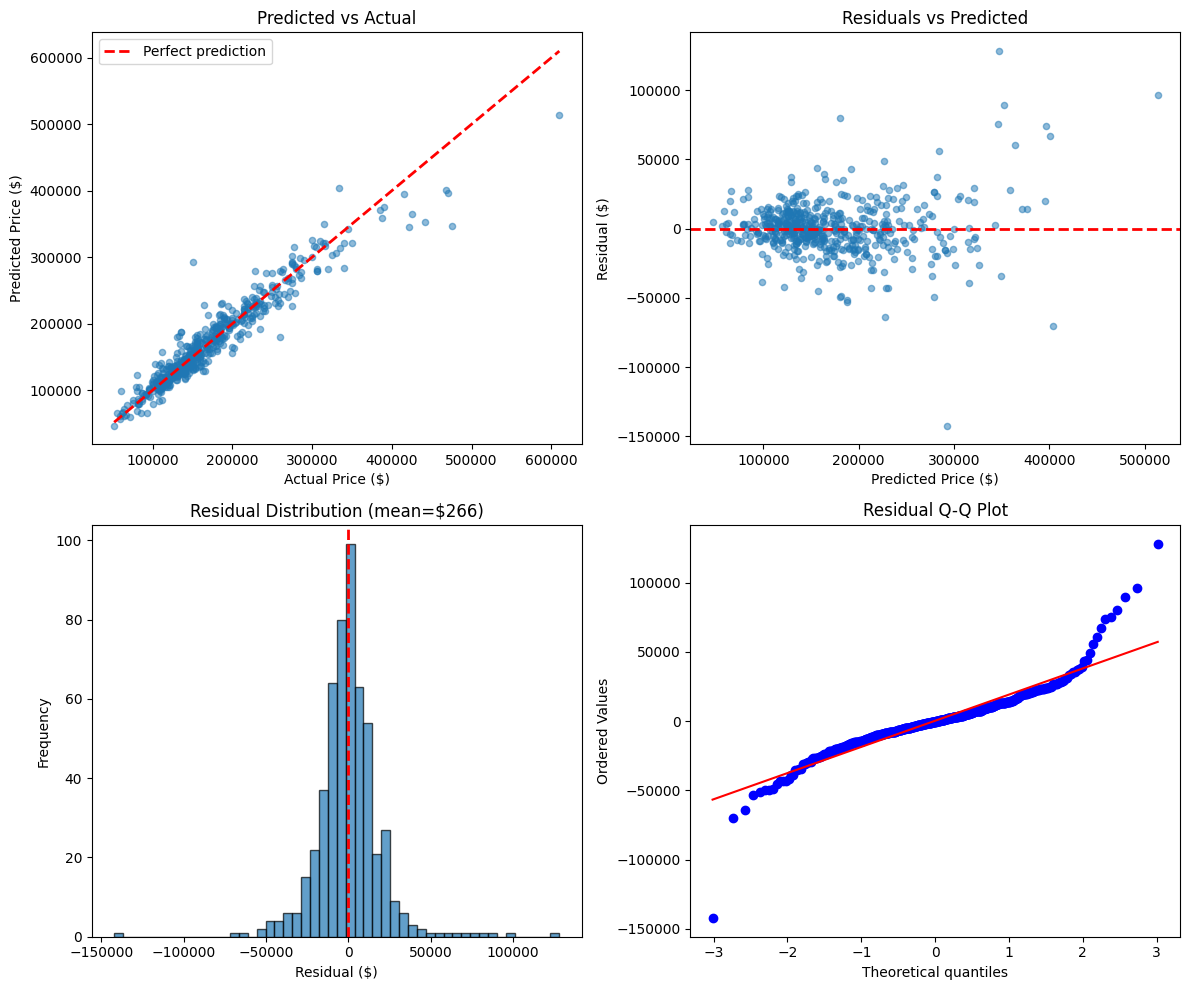


Residual statistics:
  Mean: $266 (should be ~0)
  Std:  $20,095
  Min:  $-142,174
  Max:  $128,210


In [19]:
print("\n" + "="*60)
print("STEP 11: RESIDUAL ANALYSIS")
print("="*60)

residuals = y_test - y_test_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Predicted vs Actual
ax = axes[0, 0]
ax.scatter(y_test, y_test_pred, alpha=0.5, s=20)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual Price ($)')
ax.set_ylabel('Predicted Price ($)')
ax.set_title('Predicted vs Actual')
ax.legend()

# Residuals vs Predicted
ax = axes[0, 1]
ax.scatter(y_test_pred, residuals, alpha=0.5, s=20)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted Price ($)')
ax.set_ylabel('Residual ($)')
ax.set_title('Residuals vs Predicted')

# Residual histogram
ax = axes[1, 0]
ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Residual ($)')
ax.set_ylabel('Frequency')
ax.set_title(f'Residual Distribution (mean=${np.mean(residuals):,.0f})')

# Q-Q plot
ax = axes[1, 1]
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Residual Q-Q Plot')

plt.tight_layout()
plt.savefig(project_root / 'notebooks' / 'residual_analysis.png', dpi=150)
plt.show()

print("\nResidual statistics:")
print(f"  Mean: ${np.mean(residuals):,.0f} (should be ~0)")
print(f"  Std:  ${np.std(residuals):,.0f}")
print(f"  Min:  ${np.min(residuals):,.0f}")
print(f"  Max:  ${np.max(residuals):,.0f}")


In [20]:
print("\n" + "="*60)
print("STEP 12: SAVE MODEL")
print("="*60)

import pickle

model_data = {
    'model': final_model,
    'scaler': scaler,
    'feature_names': feature_cols,
    'model_name': final_model_name,
    'params': final_params,
    'cv_score': best_cv_score,
    'test_metrics': test_metrics,
}

MODEL_PATH = Path(project_root / "models" / "final_model.pkl")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

with open(MODEL_PATH, 'wb') as f:
    pickle.dump(model_data, f)

print(f"\n✓ Model saved to: {MODEL_PATH}")



STEP 12: SAVE MODEL

✓ Model saved to: /Users/nanaagyei/Documents/Codes/machine-learning-tutorials/hands-on-ml/housing_price_project/models/final_model.pkl


In [21]:
print("\n" + "="*60)
print("PHASE 4 COMPLETE: MODEL BUILDING SUMMARY")
print("="*60)

print(f"""
DATA:
  Training samples: {X_train.shape[0]}
  Test samples: {X_test.shape[0]}
  Features: {X_train.shape[1]}

MODEL SELECTION:
  Selected: {final_model_name}
  Parameters: {final_params}
  CV R²: {best_cv_score:.4f}

TEST SET PERFORMANCE:
  R²: {test_metrics['R2']:.4f}
  RMSE: ${test_metrics['RMSE']:,.0f}
  MAE: ${test_metrics['MAE']:,.0f}
  MAPE: {test_metrics['MAPE']:.2f}%
  
vs BASELINE:
  Baseline RMSE: ${baseline_mean_rmse:,.0f}
  Our RMSE: ${test_metrics['RMSE']:,.0f}
  Improvement: {(1 - test_metrics['RMSE']/baseline_mean_rmse)*100:.1f}%

FEATURE SELECTION (Lasso):
  Selected: {n_selected}/{len(feature_names)} features
  Top predictors: Overall.Qual, area, Neighborhood, etc.

MODEL SAVED: {MODEL_PATH}
""")





PHASE 4 COMPLETE: MODEL BUILDING SUMMARY

DATA:
  Training samples: 2148
  Test samples: 537
  Features: 204

MODEL SELECTION:
  Selected: Lasso
  Parameters: {'alpha': 0.001}
  CV R²: 0.9065

TEST SET PERFORMANCE:
  R²: 0.9196
  RMSE: $20,097
  MAE: $13,162
  MAPE: 7.82%

vs BASELINE:
  Baseline RMSE: $70,880
  Our RMSE: $20,097
  Improvement: 71.6%

FEATURE SELECTION (Lasso):
  Selected: 133/204 features
  Top predictors: Overall.Qual, area, Neighborhood, etc.

MODEL SAVED: /Users/nanaagyei/Documents/Codes/machine-learning-tutorials/hands-on-ml/housing_price_project/models/final_model.pkl

